# EDA Predict Future Sales

Este es un proyecto de experimentación para predecir el total de ventas para cada producto y tieneda en el siguiente es para la compañía Rusa 1C-Company. Este proyecto hace parte de la competencia Predict Future Sales de Kaggle.

### ¿Qué realiza 1C-Company?

Es una compañía desarrolladora de software independiene. Se especializa en el desarrollo, producción, mantenimiento, licenciamiento y venta de programas informáticos, servicios relacionados y videojuegos.

El sistema de programas Enterprise 8 está destinado a la automatización de las actividades empresariales cotidianas: diversas tareas comerciales de la actividad económica y de gestión, como contabilidad de gestión, contabilidad empresarial, gestión de recursos humanos, CRM, SRM, MRP, MRP, etc.

### ¿Qué data se tiene para el proyecto?
Se nos proporcionan datos de ventas diarios para cada combinación de tienda-artículo, pero nuestra tarea es predecir las ventas a nivel mensual.

### Campos de los datos

* ID: un ID que representa una tupla (Tienda, Artículo) dentro del conjunto de prueba
* shop_id - identificador único de una tienda
* item_id - identificador único de un producto
* item_category_id - identificador único de la categoría del artículo
* item_cnt_day - número de productos vendidos. Está pronosticando una cantidad mensual de esta medida
* item_price - precio actual de un artículo
* fecha - fecha en formato dd/mm/aaaa
* date_block_num - un número de mes consecutivo, usado por conveniencia. enero de 2013 es 0, febrero de 2013 es 1,..., octubre de 2015 es 33
* item_name - nombre del elemento
* shop_name - nombre de la tienda
* item_category_name - nombre de la categoría del artículo

In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Importar datos

In [3]:
sales_train_df = pd.read_csv("Data/sales_train.csv")
item_categories_df = pd.read_csv("Data/item_categories.csv")
items_df = pd.read_csv("Data/items.csv")
sample_submission_df = pd.read_csv("Data/sample_submission.csv")
shops_df = pd.read_csv("Data/shops.csv")
test_df = pd.read_csv("Data/test.csv")

Un vistazo a los datos

In [11]:
sales_train_df.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
item_categories_df.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
items_df.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [25]:
sample_submission_df.head(5)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:
shops_df.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
test_df.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Se observa que el dataframe de sales_train contiene fechas, por lo tanto normalizamos las fechas:

In [13]:
sales_train_df.date=sales_train_df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [14]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### Agregar métricas requeridas por meses

Se realiza un agrupamiento por date_block, shop_id, item_id. Se seleccionan las columnas date, item_price, item_cnt y se le agregan las columnas necesarias mediante diccionarios indicando las columnas agregadas en cada caso:
* date: Se agregan las columnas Min-Max
* item_price: Se tiene el promedio de item_price
* item_cnt_day: Se agregan las sumas de las ventas

In [19]:
monthly_sales_df =sales_train_df.groupby(["date_block_num","shop_id","item_id"])[["date","item_price","item_cnt_day"]].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [28]:
monthly_sales_df.head(10)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0

### Número de items por categoría

In [30]:
item_categories_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


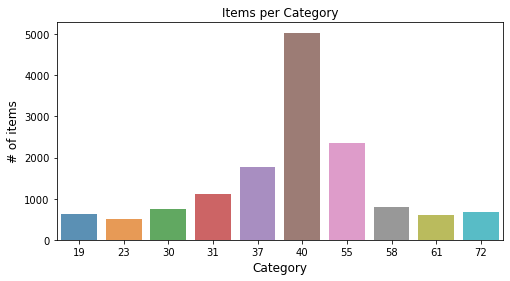

In [50]:
items_count=items_df.groupby(['item_category_id']).count()
items_count=items_count.sort_values(by='item_id',ascending=False)
items_count=items_count.iloc[0:10].reset_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(x=items_count.item_category_id, y=items_count.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()